In [ ]:
pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-9ew3n2ib
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-9ew3n2ib
  Resolved https://github.com/ultralytics/ultralytics.git to commit 03d0ffd9f58da3ad3e33908c19445c733a701015
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cv2
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wg
from ultralytics import YOLO
from IPython.display import Image, display
import os

Saving 2.jpg to 2 (5).jpg
Saving 3.jpg to 3 (5).jpg
Saving 4.jpg to 4 (5).jpg


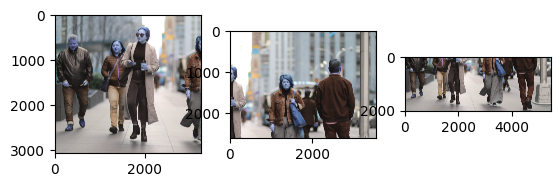

Stitched image:


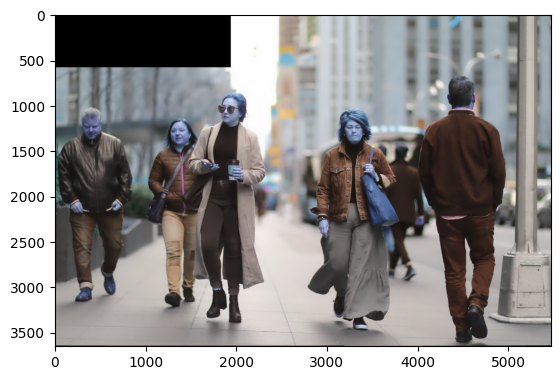

In [ ]:
######### Image Selection and Stitching #########

# Reading imgs from the user
selected_images = files.upload()
images = [cv2.imread(filename) for filename in selected_images.keys()]
s =len(images)
for i in range(s):
  plt.subplot(1,s,i+1)
  plt.imshow(images[i])
plt.show()

# Create stitcher object
stitcher = cv2.Stitcher_create()

# Attempt to stitch the images
status, stitched_image = stitcher.stitch(images)

if status == cv2.Stitcher_OK:
    print("Stitched image:")
    plt.imshow(stitched_image)
    plt.show()
else:
    print("Stitching failed.")

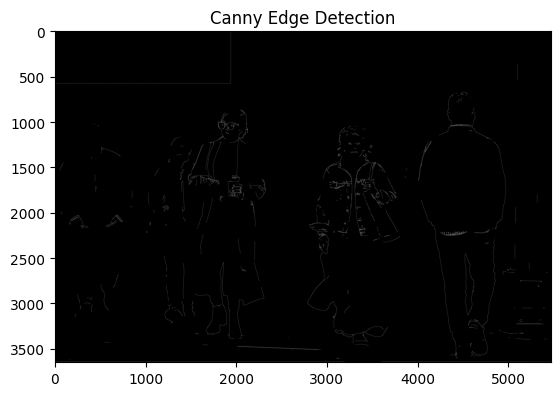

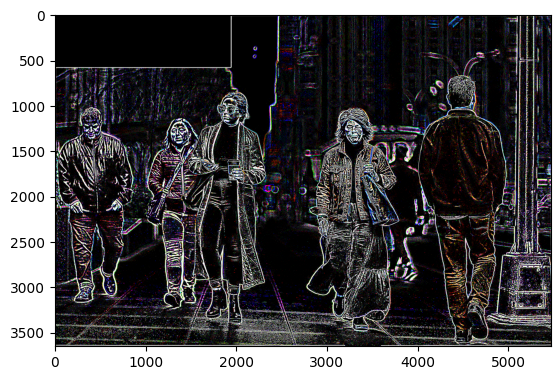

In [ ]:
######### Edge Detection Implementation #########

m =np.median(stitched_image)
lower= int(0.68*m)
upper= int(1.32*m)

# Apply automatic Canny edge detection
canny_res = cv2.Canny(stitched_image, lower, upper)
plt.imshow(canny_res, cmap='gray')
plt.title('Canny Edge Detection')
plt.show()


# Convolve the image with two gaussians (one with a scale of 1 and another with a scale of 3)
g1_image= cv2.GaussianBlur(stitched_image, (31,7), 1)
g3_image= cv2.GaussianBlur(stitched_image, (31,19), 3)

# find the difference of gaussians
DoG= g3_image-g1_image

# enhance the mask using morphological operations
# I chose the dimensions of the mask based on experimentation with the sliders below
kernel = np.ones((2, 6))
mask2 = cv2.morphologyEx(DoG, cv2.MORPH_OPEN, kernel)

plt.imshow(DoG, cmap='gray')

In [ ]:
# Define two slider to adjust the kernel size of the  morphological operation
x_slider = wg.IntSlider(value=1, min=1, max=10, description='X')
y_slider = wg.IntSlider(value=1, min=1, max=10, description='Y')
output = wg.Output()

display(x_slider, y_slider, output)

def update_kernel(change):
    x = x_slider.value
    y = y_slider.value
    kernel = np.ones((x, y))
    mask2 = cv2.morphologyEx(DoG, cv2.MORPH_OPEN, kernel)

    with output:
        output.clear_output(wait=True)  # Clear the output widget without waiting
        plt.imshow(mask2)
        plt.show()

x_slider.observe(update_kernel, names='value')
y_slider.observe(update_kernel, names='value')


IntSlider(value=1, description='X', max=10, min=1)

IntSlider(value=1, description='Y', max=10, min=1)

Output()


0: 448x640 6 persons, 161.2ms
Speed: 8.8ms preprocess, 161.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict5


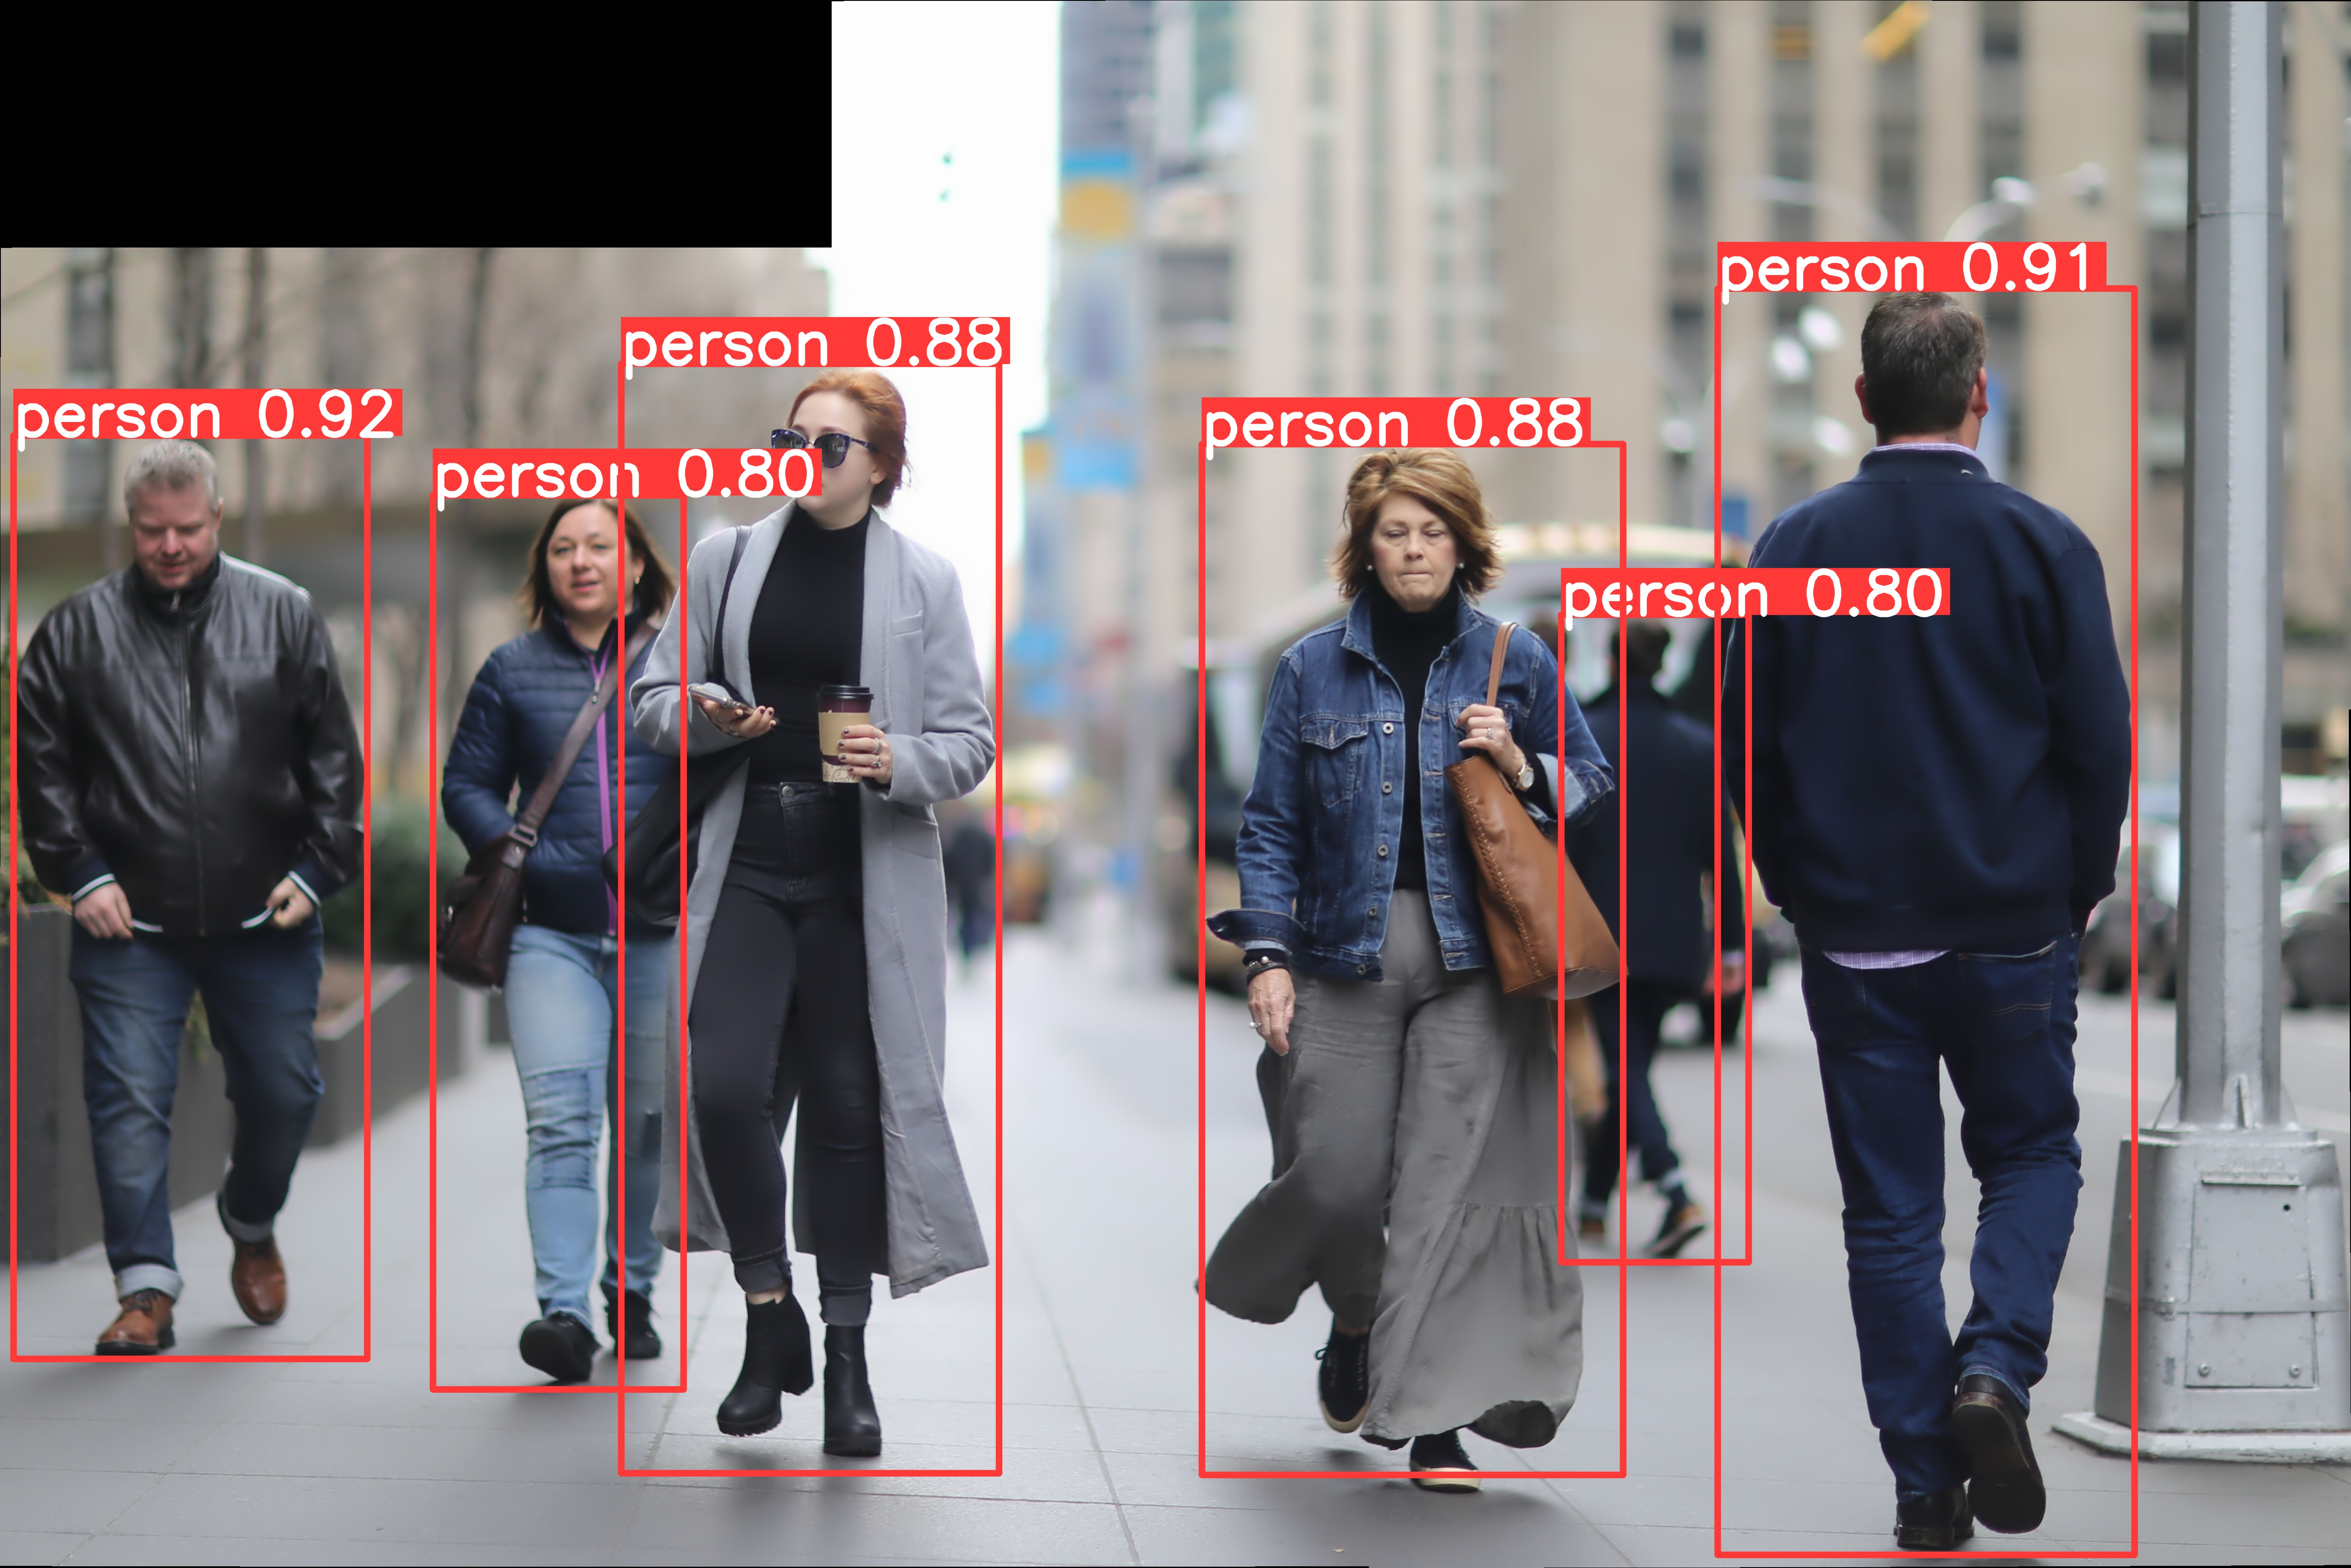

In [ ]:
######### AI-based Human Edge Detection #########

# Initialize YOLO8 model
# yolov8n model provide a good balance between accuracy and resource consumption.
model = YOLO('yolov8n.pt')

# Perform object detection
results = model(stitched_image,  conf = 0.5, model ='person',save=True)

results_dir = "runs/detect/predict"

# List all files in the directory
result_files = os.listdir(results_dir)

# Display each result
for file_name in result_files:
    # Check if the file is an image file
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
        # Load the image
        image_path = os.path.join(results_dir, file_name)

        # Display the image
        display(Image(image_path))